# Ensemble of different architectures

## Start

In [72]:
#Create references to important directories we will use over and over
import os, sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize_scalar
import time
import seaborn as sns
import pandas as pd
import keras
from datetime import datetime
#from utils import *
from keras import backend as K
K.set_image_dim_ordering('tf')
%matplotlib inline
sns.set()

from PIL import Image
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Input, Dropout
from keras.applications import xception, resnet50, imagenet_utils
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [2]:
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/data/dogscats'

path = DATA_HOME_DIR + '/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
predictions_path = DATA_HOME_DIR + '/results/predictions/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'

In [3]:
MODEL = resnet50.ResNet50
input_shape=(299, 299, 3)
preprocess=imagenet_utils.preprocess_input

## Generate augmented images to bottleneck from

In [3]:
def generate_augmented_images(input_shape=(299, 299, 3), batch_size=20, aug_mult=1):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299

    train_gen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         horizontal_flip=True)

    train_batches = train_gen.flow_from_directory(train_path,
                                                  shuffle=False,        ###############
                                                  batch_size=batch_size, 
                                                  class_mode='categorical', 
                                                  target_size=input_shape[:-1])
    
    # create dirs for each class
    %cd $path
    for fn in set(map(os.path.dirname, train_batches.filenames)):
        os.makedirs(f'{train_aug_dir}/{fn}', exist_ok=True)
        
    
    for i in enumerate(tqdm(range(int(train_batches.samples/train_batches.batch_size*aug_mult)))):
        batch = train_batches.next()
        idx = ((train_batches.batch_index - 1)*train_batches.batch_size)%train_batches.samples
        filenames = train_batches.filenames[idx:idx+train_batches.batch_size]

        # TODO:
        assert len(filenames) == len(batch[0]), 'train_batch.samples is not divisible by batch_size'

        for img, filename in zip(batch[0], filenames):
            new_filename = f'{path}/{train_aug_dir}/{filename.split(".jpg")[-2]}.{i[0]}.jpg'
            Image.fromarray(img.swapaxes(1, 2).transpose().astype('uint8')).save(new_filename)

In [4]:
generate_augmented_images(input_shape=input_shape, aug_mult=5)

Found 23000 images belonging to 2 classes.
C:\Python\AI\data\dogscats


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5750/5750 [52:36<00:00,  1.82it/s]


In [ ]:
from keras.applications.xception.

## Generate bottlenecks

In [13]:
def generate_bottlenecks(MODEL=xception.Xception, input_shape=(299, 299, 3), batch_size=20, preprocess=xception.preprocess_input):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
    # generator will load augmented samples
    gen = image.ImageDataGenerator(preprocessing_function=preprocess)
    train_batches = gen.flow_from_directory(path+train_aug_dir,
                                            shuffle=False,
                                            batch_size=batch_size, 
                                            class_mode='categorical', 
                                            target_size=input_shape[:-1])
    valid_batches = gen.flow_from_directory(valid_path,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            target_size=input_shape[:-1])
    test_batches = gen.flow_from_directory(test_path,
                                           shuffle=False,
                                           batch_size=batch_size,
                                           class_mode=None,
                                           target_size=input_shape[:-1])

    model = MODEL(include_top=False, 
                  weights='imagenet', 
                  #input_tensor=x, 
                  input_shape=input_shape, 
                  pooling='avg')
    # save conv predictions after avg pooling layer as features
    # train set - images and labels
    train_features = model.predict_generator(train_batches, train_batches.n/train_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_train_features.bc', train_features)
    save_array(f'{model_path}/{MODEL.__name__}_train_labels.bc', to_categorical(train_batches.classes))
    
    # validation set - images, labels and filenames
    valid_features = model.predict_generator(valid_batches, valid_batches.n/valid_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_valid_features.bc', valid_features)
    save_array(f'{model_path}/{MODEL.__name__}_valid_labels.bc', to_categorical(valid_batches.classes))
    save_array(f'{model_path}/{MODEL.__name__}_valid_filenames.bc', valid_batches.filenames)
    
    # test set - images and filenames(ids)
    test_features = model.predict_generator(test_batches, test_batches.n/test_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_test_features.bc', test_features)
    save_array(f'{model_path}/{MODEL.__name__}_test_filenames.bc', list(map(lambda filename: 
                                                                               int(filename[8:].split('.jpg')[-2]), 
                                                                            test_batches.filenames)))
    
generate_bottlenecks(MODEL=MODEL, input_shape=input_shape, batch_size=20, preprocess=preprocess)

Found 138000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
625/625 [==============================] - 420s   


#### Dirty hack for now

In [ ]:
#MODEL=xception.Xception
#input_shape=(299, 299, 3)
batch_size=20
#preprocess=xception.preprocess_input

train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
# generator will load augmented samples
gen = image.ImageDataGenerator(preprocessing_function=preprocess)
train_batches = gen.flow_from_directory(path+train_aug_dir,
                                        shuffle=False,
                                        batch_size=batch_size, 
                                        class_mode='categorical', 
                                        target_size=input_shape[:-1])

# preprocess input
#x = keras.layers.Input(input_shape)
#if preprocess:
#    x = keras.layers.Lambda(preprocess, input_shape=input_shape)(x)

model = MODEL(include_top=False, 
              weights='imagenet', 
              #input_tensor=x, 
              input_shape=input_shape, 
              pooling='avg')
# save conv predictions after avg pooling layer as features
# validation set - images, labels and filenames
train_features = model.predict_generator(train_batches, 10, verbose=1)
#save_array(f'{model_path}/{MODEL.__name__}_valid_features123.bc', valid_features)
#save_array(f'{model_path}/{MODEL.__name__}_valid_labels123.bc', valid_batches.classes)
#save_array(f'{model_path}/{MODEL.__name__}_valid_filenames123.bc', valid_batches.filenames)

# model = keras.models.Sequential()
# dropout_p = 0.5

# model.add(Dense(2048, input_shape=(2048,), activation='relu'))
# model.add(Dropout(dropout_p))
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(dropout_p))
# model.add(Dense(2, activation='softmax'))

# model.compile(Adam(lr=0.002), 'categorical_crossentropy', metrics=['acc'])
# model.fit(train_features, train_batches.classes[:200], batch_size=10, epochs=1)

## Make a new model

In [4]:
def get_features(MODEL=xception.Xception):
    train_features = load_array(f'{model_path}/{MODEL.__name__}_train_features.bc')
    train_labels = load_array(f'{model_path}/{MODEL.__name__}_train_labels.bc')
    valid_features = load_array(f'{model_path}/{MODEL.__name__}_valid_features.bc')
    valid_labels = load_array(f'{model_path}/valid_labels.bc')
    valid_filenames = load_array(f'{model_path}/valid_filenames.bc')
    test_features = load_array(f'{model_path}/{MODEL.__name__}_test_features.bc')
    test_filenames = load_array(f'{model_path}/test_filenames.bc')
    return (train_features, train_labels, 
           valid_features, valid_labels, valid_filenames, 
           test_features, test_filenames)

(train_features, train_labels, 
 valid_features, valid_labels, valid_filenames, 
 test_features, test_filenames) = get_features(MODEL)

In [29]:
Resnet = keras.applications.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling='avg', )

In [30]:
Resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_9[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_393 (Activation)      (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [47]:
# new model
model = keras.models.Sequential()
dropout_p = 0.7
batch_size = 10000

model.add(Dense(2048, input_shape=(2048,), activation='relu'))
model.add(Dropout(dropout_p))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(dropout_p))
model.add(Dense(2, activation='softmax'))

model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['acc'])
log_dir = path + 'logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
tb_cb = TensorBoard(log_dir=log_dir, batch_size=batch_size, write_batch_performance=True)

In [60]:
model.fit(train_features, train_labels, batch_size=batch_size, epochs=1, validation_data=(valid_features, valid_labels), callbacks=[tb_cb])

Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0268 - val_acc: 0.9910


In [38]:
model.compile(SGD(lr=0.02), 'categorical_crossentropy', metrics=['acc'])

In [39]:
model.fit(train_features, train_labels, batch_size=batch_size, epochs=1, validation_data=(valid_features, valid_labels), callbacks=[tb_cb])

Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0103 - acc: 0.9963 - val_loss: 0.0326 - val_acc: 0.9910


In [69]:
model.evaluate(valid_features, valid_labels)

1952/2000 [============================>.] - ETA: 0s

[0.031924323571845888, 0.98699999999999999]

In [58]:
model.save_weights(results_path+'resnet_bnda6_v0.0254_8.h5')

In [61]:
model.load_weights(results_path+'resnet_bnda6_v0.0254_8.h5')

In [62]:
test_preds = model.predict(test_features, batch_size=10000)
valid_preds = model.predict(valid_features, batch_size=10000)

In [63]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    import itertools
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(classes))
    tick_marks = []
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[993   7]
 [ 10 990]]


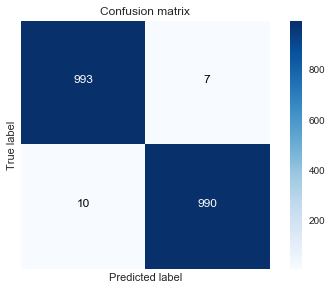

In [64]:
isdog = test_preds[:, 1]
val_isdog = valid_preds[:, 1]
val_predicted_labels = np.round(val_isdog)
val_expected_labels = valid_labels[:, 1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_expected_labels, val_predicted_labels)
plot_confusion_matrix(cm, ['cat', 'dog'])

In [65]:
from keras.preprocessing import image
from numpy.random import permutation
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots(ims, figsize=(24,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + valid_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 8

Found 17 incorrect labels


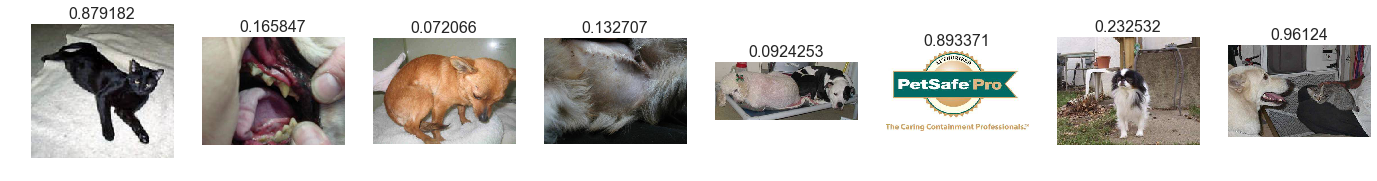

In [75]:
#2. A few incorrect labels at random
incorrect = np.where(val_expected_labels!=val_predicted_labels)[0]
print(f"Found {len(incorrect)} incorrect labels")
idx = permutation(incorrect)[:n_view]
plots_idx(idx, val_isdog[idx])

In [67]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
print('precision:', precision_score(val_expected_labels, val_predicted_labels)) 
print('recall:', recall_score(val_expected_labels, val_predicted_labels)) 
print('accuracy:', accuracy_score(val_expected_labels, val_predicted_labels))

precision: 0.99297893681
recall: 0.99
accuracy: 0.9915


In [68]:
import scipy
min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(val_expected_labels, val_isdog, eps=x), bounds=(1e-10, 0.1), method='bounded')
min_logloss

     fun: 0.025359089265925148
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 6.6107961285789138e-06

In [69]:
eps = np.clip(min_logloss.x, 0.005, 0.05)
min_logloss_f = log_loss(val_expected_labels, val_isdog, eps=eps)
isdog = isdog.clip(min=eps, max=1-eps)

In [73]:
subm = np.stack([test_filenames, isdog], axis=1)
%cd $DATA_HOME_DIR
submission_file_name = 'submission14.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')
pd.read_csv(submission_file_name, index_col='id')

C:\Python\AI\data\dogscats


,label
id,
1,0.99500
10,0.00500
100,0.00500
1000,0.99500
10000,0.99500
10001,0.00500
10002,0.00500
10003,0.99500
10004,0.98294


In [74]:
submission_message = f"Resnet50 with BN and DAx6 bottlenecks -- resnet_bnda6_v0.0254_8.h5 logloss={min_logloss_f:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.05028
